## Кубические сплайны

$\textbf{Кубический сплайн}$ (дефекта 1), интерполирующий $f(x)$ на $[a, b]$: $$c(x) := d_k + c_k (x-x_k) + b_k (x-x_k)^2 + a_k (x-x_k)^3,$$ 

где $x\in [x_{k-1}, x_{k}] \big|_{k=1}^n$

$\textbf{Обозначение кубического сплайна дефекта 1}$: $S^n_{3,2}$, где $n, 3, 2$ - кол-во узлов интерполирования, старшая степень и порядок гладкости сплайна соответственно.

$\textbf{Краевые условия}$: 
$$ \textbf{1)}\; c(x_k) = f(x_k), \;\; \textbf{2)}\; c(x) \in C^2([a,b]), \;\; \textbf{3)}\; c''(a) = c''(b)=0$$
При выполнении условия $\textbf{3)}$ сплайн называется $\textbf{естественным}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
np.set_printoptions(suppress=True)

In [2]:
# Матрица в виде AB = C
# Исходная функция
def fn(x):
    return x**2 + 4*np.sin(x) - 2

Text(0.5, 1.0, 'Интерполируемая функция')

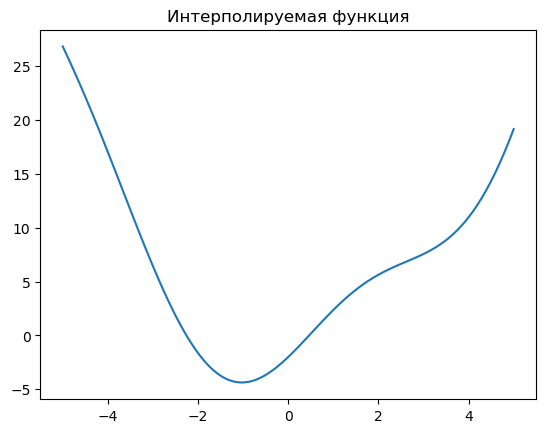

In [5]:
x = np.linspace(-5, 5, 100)
plt.plot(x, fn(x))
plt.title(f'Интерполируемая функция')

## Кубические сплайны по равноотстоящим узлам

In [3]:
def cub_spline(arg, a, b, m, fig=None):
    x = np.linspace(a, b, m)
    # m - число узлов
    n = m - 1
    # n - число кубических сплайнов

    A = np.zeros((4*n, 4*n))
    C = np.zeros(4*n)

    for i in range(n):
        A[i, i] = x[i]**3
        A[i, n+i] = x[i]**2
        A[i, 2*n+i] = x[i]
        A[i, 3*n+i] = 1

        # Строки [n, 2n-1]
        A[n+i, i] = x[i+1]**3
        A[n+i, n+i] = x[i+1]**2
        A[n+i, 2*n+i] = x[i+1]
        A[n+i, 3*n+i] = 1

        C[i] = fn(x[i])
        C[n+i] = fn(x[i+1])

    # Строки [2n, 3n-1]
    for j in range(n-1):
        row = 2*n+j
        columns = [j, j+1, n+j, n+j+1, 2*n+j, 2*n+j+1]
        # start at j+1 since derivatives are equal at the interior points
        values = 3*x[j+1]**2, -3*x[j+1]**2, 2*x[j+1], -2*x[j+1], 1, -1
        A[row, [columns]] = values

        # Значения функции для рядов C из промежутка [2n: 3n-1] равны нулю, 
        # поскольку мы приравниваем произвдоные

    # Строки [3n-1, 4n-2]
    for q in range(n-1):
        row = 3*n-1 + q
        columns = [q, q+1, n+q, n+q+1]
        values = 6*x[q+1], -6*x[q+1], 2, -2
        A[row, [columns]] = values
        # Значения функции для рядов C из промежутка [3n-1: 4n-2] равны нулю, 
        # поскольку мы приравниваем произвдоные

    # Задаем вторые производные на граничны точках (x0, xn) равными нулю, 
    # чтобы получить два дополнительных уравнения - естественный сплайн
    A[4*n-2, [0,n]] = 6*x[0], 2
    A[4*n-1, [n-1,2*n-1]] =  6*x[n], 2

    # Решаем относительно b
    B = np.linalg.solve(A,C)

    ai = B[:n]
    bi = B[n:2*n]
    ci = B[2*n:3*n]
    di = B[3*n:]
    
    # Вычисление значения от кубического сплайна     
    if fig == None:
        flag, res = 0, 0
        eps = 10**(-6)
        for i in range(n):
            if arg == a:
                arg += eps
                flag = i
                res = ai[flag]*arg**3 + bi[flag]*arg**2 + ci[flag]*arg + di[flag]
            elif arg == b:
                arg -= eps
                flag = i
                res = ai[flag]*arg**3 + bi[flag]*arg**2 + ci[flag]*arg + di[flag]
            elif (arg > x[i]) and (arg < x[i+1]):
                flag = i
                res = ai[flag]*arg**3 + bi[flag]*arg**2 + ci[flag]*arg + di[flag]
        return res

    # Изображение на графике     
    elif fig == True:
        plt.figure()
        for k in range(n):
            xspline = np.linspace(x[k], x[k+1])
            yspline = ai[k]*xspline**3 + bi[k]*xspline**2 + ci[k]*xspline + di[k]    
            plt.plot(xspline, yspline, '-', linewidth=4)

        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('$S_{3,2}^m$ по равноотстоящим узлам для $f(x)$')
        plt.show()

In [4]:
cub_spline(arg=-10, a=-10, b=10, m=100)

100.17606107660163

## Изобразим $S_{3,2}^{m}$

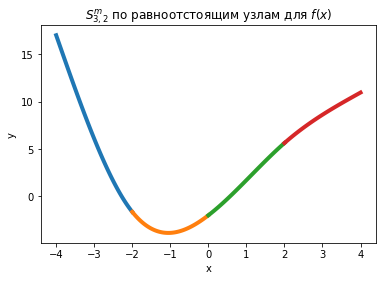

In [5]:
cub_spline(arg=5, a=-4, b=4, m=5, fig=True)

## Кубические сплайны по оптимальным узлам Чебышева $$x_i = 0.5 \left((b-a)\cos\dfrac{(2i+1)\pi}{2(n+1)} + (b+a)\right),\; i\in \overline{0,n}$$

In [6]:
def optimal_cub_spline(arg, a, b, m, fig=None):
    chebish = []
    n = m - 1
    for i in range(0, m):
        chebish.append(0.5 * ((b-a)*np.cos(((2*i+1)*np.pi)/(2*(m+1))) + (b+a)))

    A_opt = np.zeros((4*n, 4*n))*1.0
    C_opt = np.zeros(4*n)*1.0

    for i in range(n):
        A_opt[i, i] = chebish[i]**3
        A_opt[i, n+i] = chebish[i]**2
        A_opt[i, 2*n+i] = chebish[i]
        A_opt[i, 3*n+i] = 1

        # Строки [n, 2n-1]
        A_opt[n+i, i] = chebish[i+1]**3
        A_opt[n+i, n+i] = chebish[i+1]**2
        A_opt[n+i, 2*n+i] = chebish[i+1]
        A_opt[n+i, 3*n+i] = 1

        C_opt[i] = fn(chebish[i])
        C_opt[n+i] = fn(chebish[i+1])

    # Строки [2n, 3n-1]
    for j in range(n-1):
        row = 2*n+j
        columns = [j, j+1, n+j, n+j+1, 2*n+j, 2*n+j+1]
        # start at j+1 since derivatives are equal at the interior points
        values = 3*chebish[j+1]**2, -3*chebish[j+1]**2, 2*chebish[j+1], -2*chebish[j+1], 1, -1
        A_opt[row, [columns]] = values

        # Строки [3n-1, 4n-2]
    for q in range(n-1):
        row = 3*n-1 + q
        columns = [q, q+1, n+q, n+q+1]
        values = 6*chebish[q+1], -6*chebish[q+1], 2, -2
        A_opt[row, [columns]] = values

    # Задаем вторые производные на граничны точках (x0, xn) равными нулю, 
    # чтобы получить два дополнительных уравнения - естественный сплайн
    A_opt[4*n-2, [0,n]] = 6*chebish[0], 2
    A_opt[4*n-1, [n-1,2*n-1]] =  6*chebish[n], 2

    # Решаем относительно b
    B_opt = np.linalg.solve(A_opt, C_opt)

    ai_opt = B_opt[:n]
    bi_opt = B_opt[n:2*n]
    ci_opt = B_opt[2*n:3*n]
    di_opt = B_opt[3*n:]
    
    # Вычисление значения от кубического сплайна   
    if fig == None:
        flag, res = 0, 0
        eps = 10**(-1)
        for i in range(n):
            if arg == a:
                arg += eps + 0.9
                flag = i
                res = ai_opt[flag]*arg**3 + bi_opt[flag]*arg**2 + ci_opt[flag]*arg + di_opt[flag]
            elif arg == b:
                arg -= eps
                flag = i
                res = ai_opt[flag]*arg**3 + bi_opt[flag]*arg**2 + ci_opt[flag]*arg + di_opt[flag]
            elif (arg < chebish[i]) and (arg > chebish[i+1]):
                flag = i
                res = ai_opt[flag]*arg**3 + bi_opt[flag]*arg**2 + ci_opt[flag]*arg + di_opt[flag]
        return res

    # Изображение на графике     
    elif fig == True:
        plt.figure()
        for k in range(n):
            xspline = np.linspace(chebish[k], chebish[k+1])
            yspline = ai_opt[k]*xspline**3 + bi_opt[k]*xspline**2 + ci_opt[k]*xspline + di_opt[k]    
            plt.plot(xspline, yspline, '-', linewidth=4)

        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('$S_{3,2}^m$ по узлам Чебышева для $f(x)$')
        plt.show()

In [7]:
optimal_cub_spline(arg=10, a=-10, b=10, m=10, fig=None)

94.1781250037786

## Изобразим $S_{3,2}^{m_{opt}}$

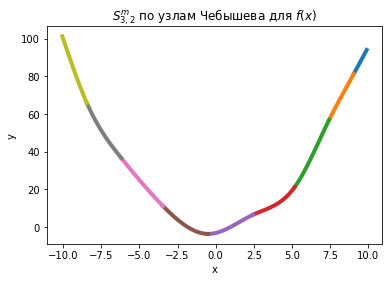

In [8]:
optimal_cub_spline(arg=1, a=-11, b=10, m=7, fig=True)

## Найдем максимальные отклонения $RS_{3,2}^n, RS_{3,2}^{n_{opt}}$

In [146]:
k = int(input('Введите количество k точек разбиения интервала интерполирования, в которых определяются отклонения: '))
max_nodes = int(input('Введите максимальное количество max_nodes узлов: '))
# mds = maximum_difference_segment
a = float(input('Введите a: '))
b = float(input('Введите b: '))
mds = np.linspace(a, b, k)

func_mds = []
spline_mds = []
optimal_spline_mds = []
RSn_mp = []
RSn_opt_mp = []

# значения точной функции в точках x0, x1, ..., xm; m >> n
for i in mds:
    func_mds.append(fn(i))

print('Таблица 1:')
print('-----------------------------------------------------------------------------------------------------------')
print('| кол-во узлов, n | кол-во точек разбиения, k   | max RSn_mp \t\t | max RSn_opt_mp \t\t|' )
print('-----------------------------------------------------------------------------------------------------------')

for pp in range(3, max_nodes + 1):
    # Ищем отклонения     
    for p in mds:
        # значения линейного сплайна S_{3,2}^n в точках x0, x1, ..., xk; k >> n  
        spline_mds.append(cub_spline(arg=p, a=a, b=b, m=pp))
        # значения линейного сплайна S_{3,2}^{n_opt} в точках x0, x1, ..., xk; k >> n        
        optimal_spline_mds.append(optimal_cub_spline(arg=p, a=a, b=b, m=pp))    
    # Отклонения
    for j in range(1, len(mds)):
        RSn_mp.append(np.absolute(func_mds[j] - spline_mds[j]))
        RSn_opt_mp.append(np.absolute(func_mds[j] - optimal_spline_mds[j]))
    RSn_mp_max = max(RSn_mp)
    RSn_opt_mp_max = max(RSn_opt_mp)
    
    print('|\t', pp, '\t|\t\t', k, '\t  |', RSn_mp_max, '\t|', RSn_opt_mp_max, '\t\t |')
    print('-----------------------------------------------------------------------------------------------------------')
    RSn_mp = []
    RSn_opt_mp = []
    RSn_mp_max, RSn_opt_mp_max = 0, 0
    spline_mds = []
    optimal_spline_mds = []

Введите количество k точек разбиения интервала интерполирования, в которых определяются отклонения: 15
Введите максимальное количество max_nodes узлов: 10
Введите a: -10
Введите b: 10
Таблица 1:
-----------------------------------------------------------------------------------------------------------
| кол-во узлов, n | кол-во точек разбиения, k   | max RSn_mp 		 | max RSn_opt_mp 		|
-----------------------------------------------------------------------------------------------------------
|	 3 	|		 15 	  | 11.873489430292693 	| 68.45544084534349 		 |
-----------------------------------------------------------------------------------------------------------
|	 4 	|		 15 	  | 9.278314703978992 	| 68.45544084534349 		 |
-----------------------------------------------------------------------------------------------------------
|	 5 	|		 15 	  | 8.682818478267123 	| 68.45544084534349 		 |
-----------------------------------------------------------------------------------------------------

## Графики распределения абсолютной погрешности на $[a,b]$ при некоторых $n$

## $N_n$

In [147]:
from sympy import sin, cancel, Symbol, cos
def fun(x):
    x = Symbol('x')
    return x**2 + 4*sin(x) - 2

In [148]:
x = Symbol('x')

# вычисляем полином Ньютона, N_k
def newton_polynomial(a, b, k):
    nodes = np.linspace(a, b, k)
    x = Symbol('x')
    func_val = []
    for i in nodes:
        func_val.append(fun(i))
        
    # поститать f(x0; ...; xk) - разделенные разности
    def divided_differences(k):
        f_x0_to_xk, prod = 0, 1
        for j in range(0, k + 1):
            for i in range(0, k + 1):
                if i != j:
                    prod *= (nodes[j]-nodes[i])
            f_x0_to_xk += func_val[j] / prod
            prod = 1
        return f_x0_to_xk
    
    product = 1
    newton = divided_differences(0)
    for i in range(1, k):
        product *= (x-nodes[i-1])
        newton += divided_differences(i)*product
    newt = cancel(newton)
    return newt

## $N_{n_{opt}}$


In [149]:
def optimal_newtone_interpolate(a, b, k):
    """Вычисление и.п. Ньютона по n оптимальным узлам Чебышева"""
    x = Symbol('x')
    
    # оптимальные узлы Чебышева
    chebischev_nodes = []
    for i in range(0, k):
        chebischev_nodes.append(0.5 * ((b-a)*cos(((2*i+1)*np.pi)/(2*(k+1))) + (b+a)))
    
    func_val = []
    for j in chebischev_nodes:
        func_val.append(fun(j))
        
    def divided_differences(k):
        f_x0_to_xk, prod = 0, 1
        for j in range(0, k + 1):
            for i in range(0, k + 1):
                if i != j:
                    prod *= (chebischev_nodes[j]-chebischev_nodes[i])
            f_x0_to_xk += func_val[j] / prod
            prod = 1
        return f_x0_to_xk
    
    product = 1
    newton = divided_differences(0)
    for i in range(1, k):
        product *= (x-chebischev_nodes[i-1])
        newton += divided_differences(i)*product
    
    res = cancel(newton)
    return res

In [161]:
from importlib import reload
plt=reload(plt)

Введите максимальное количество max_nodes_abs_diff узлов: 15


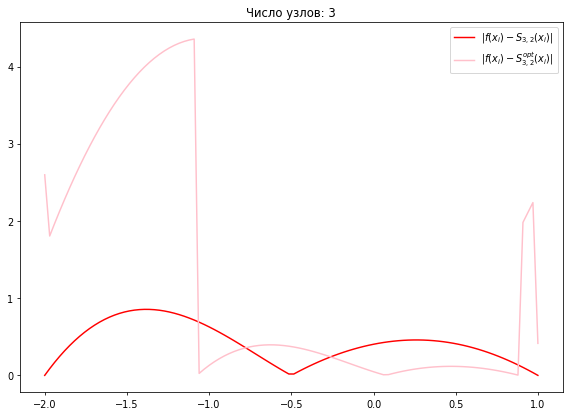

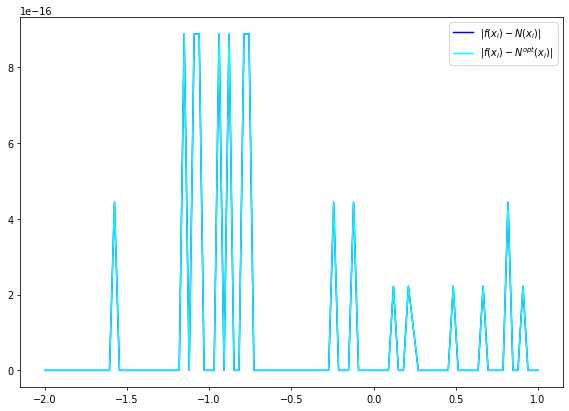

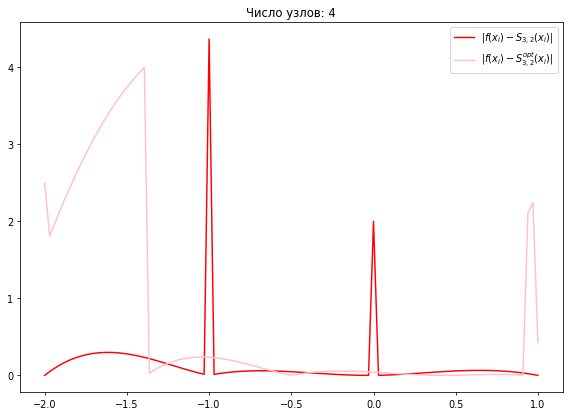

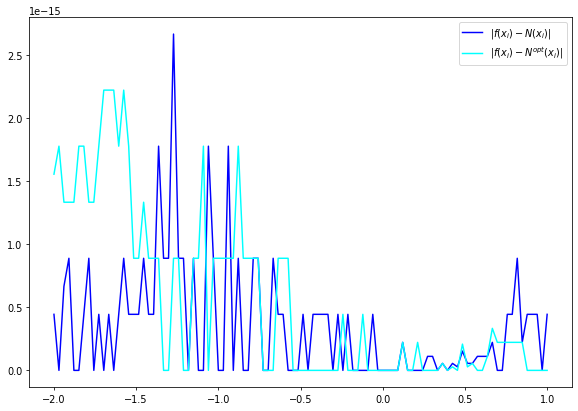

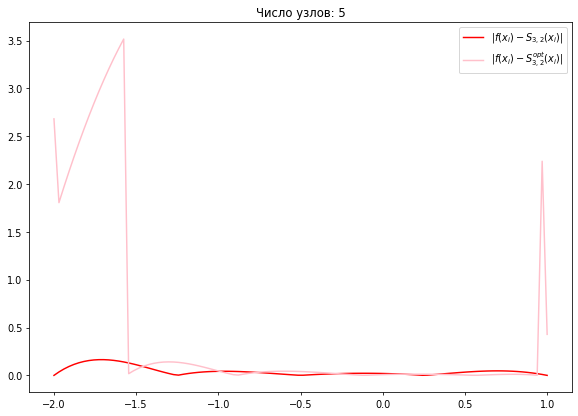

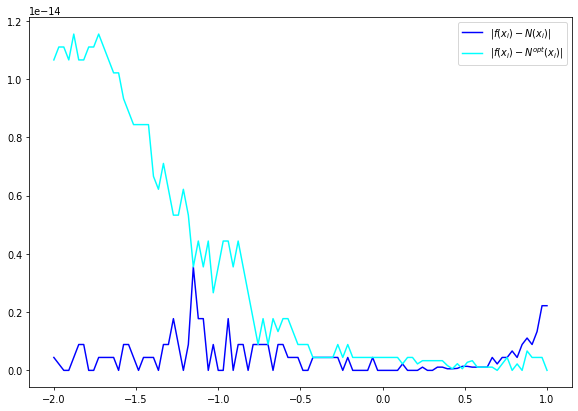

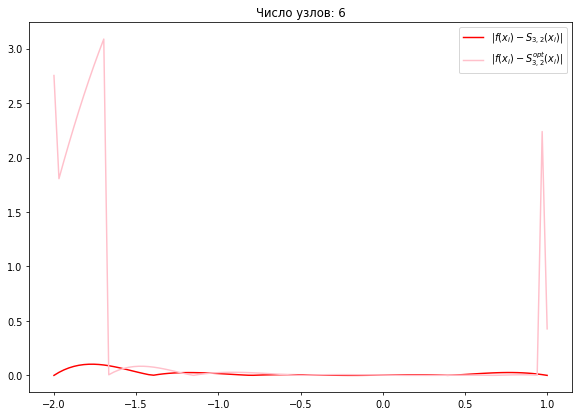

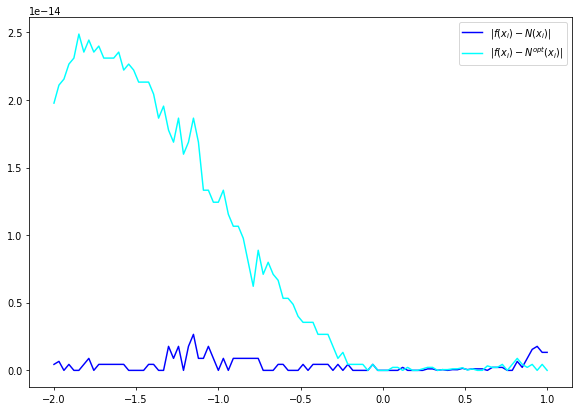

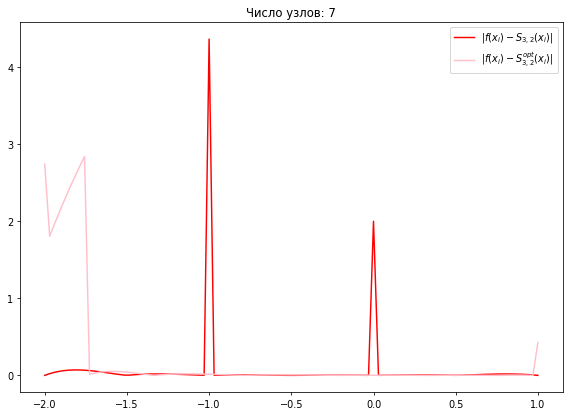

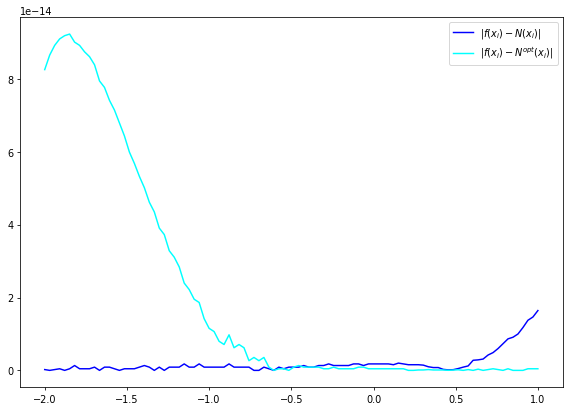

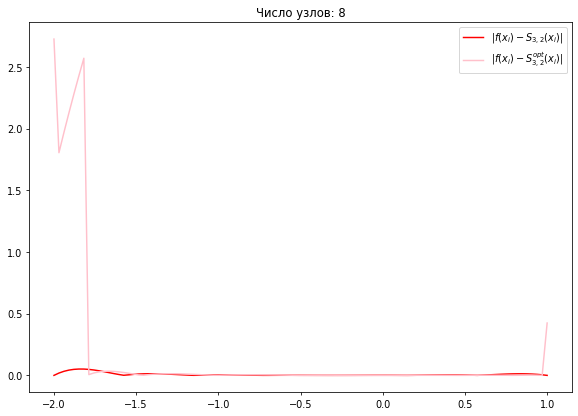

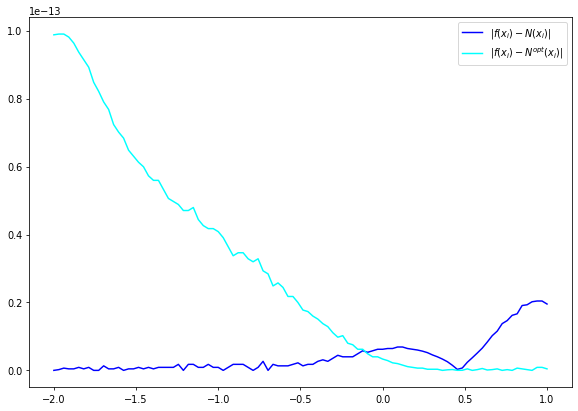

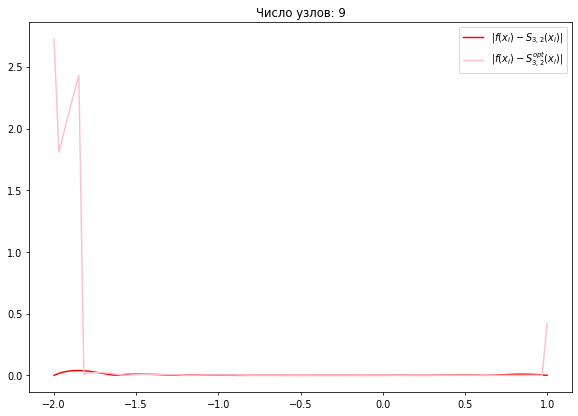

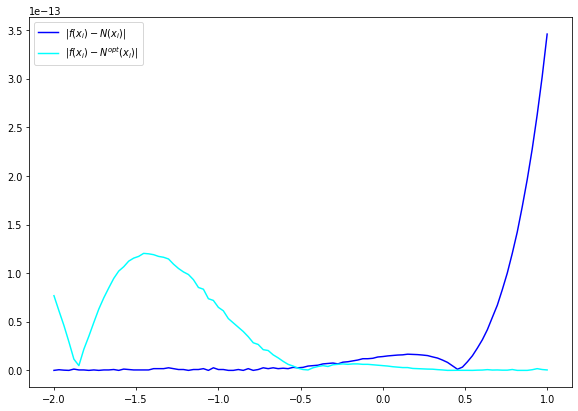

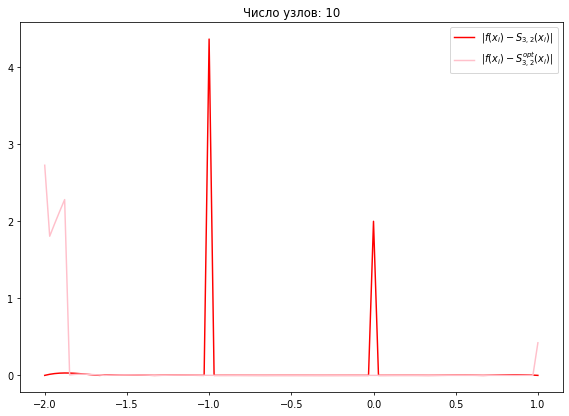

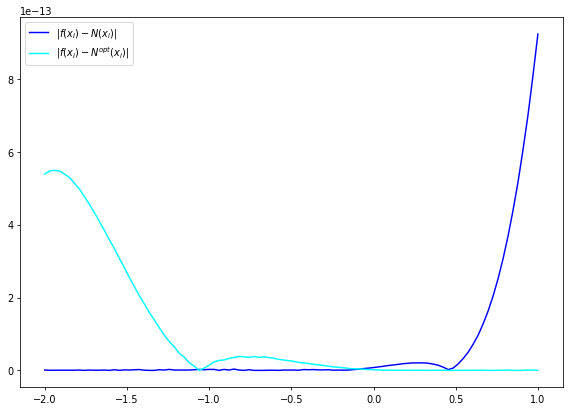

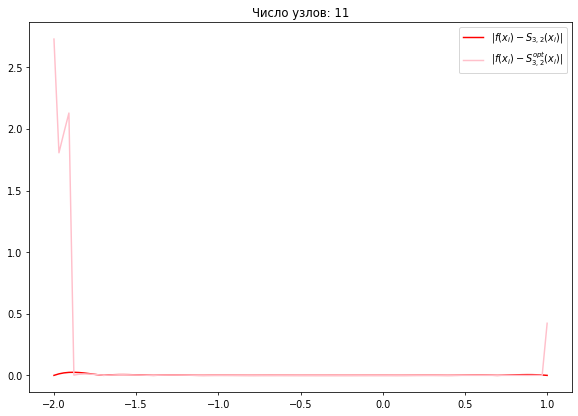

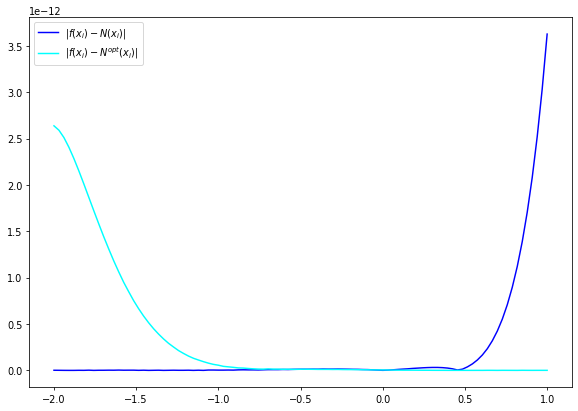

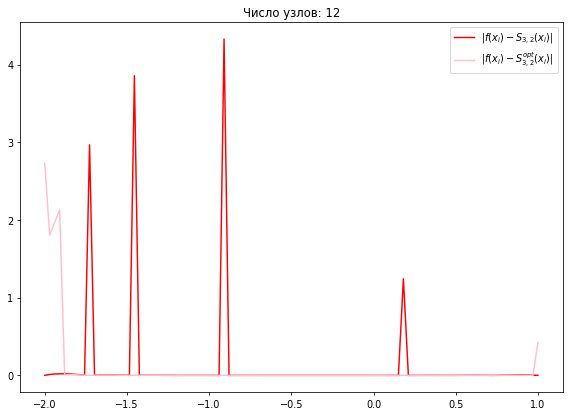

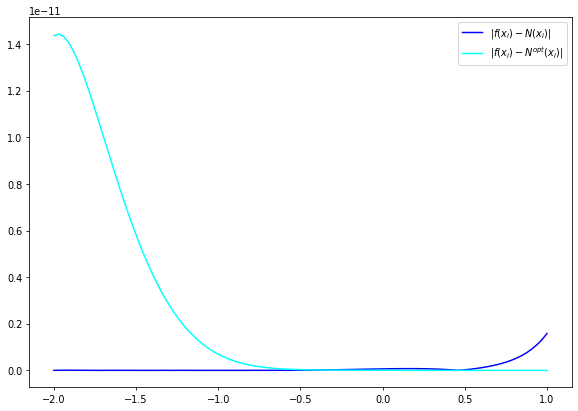

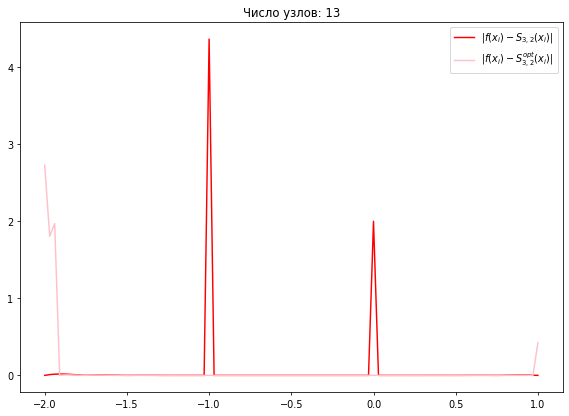

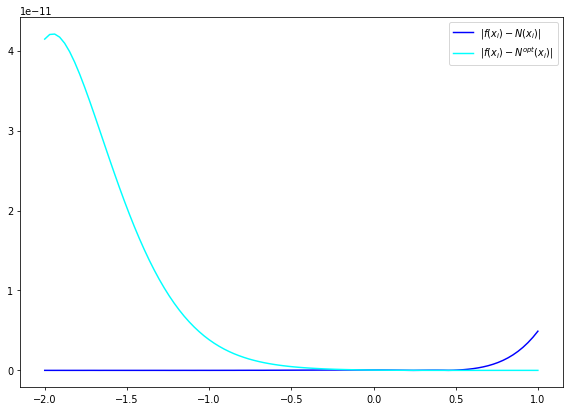

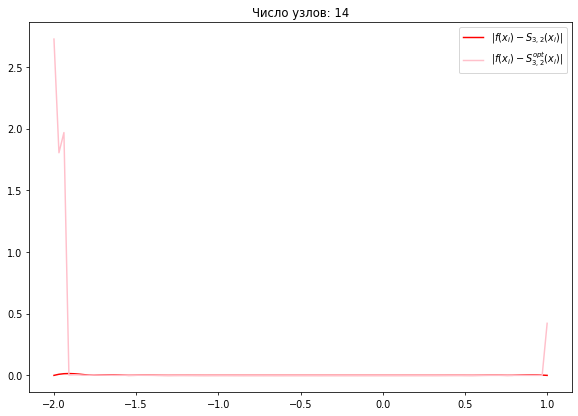

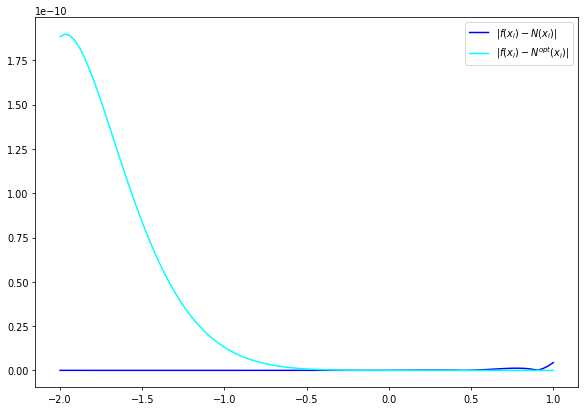

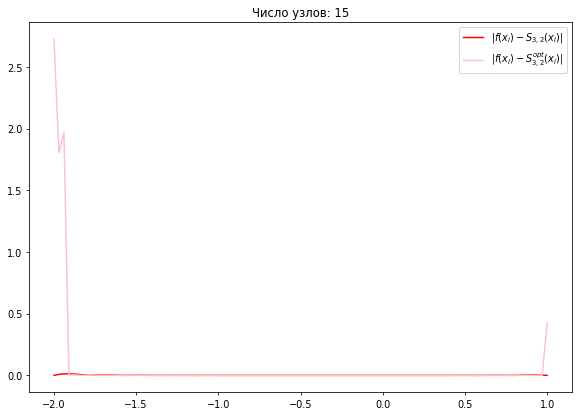

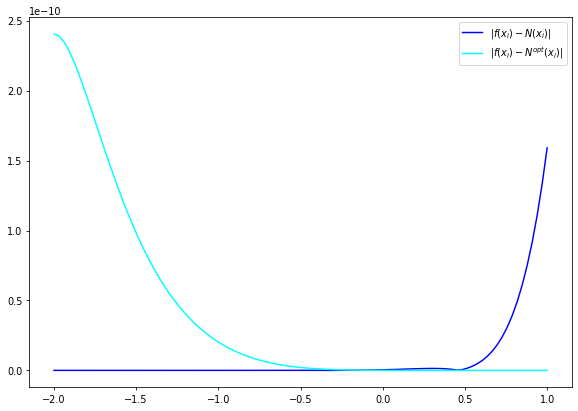

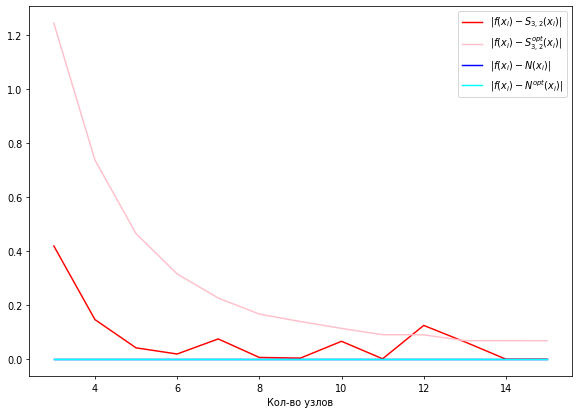

In [205]:
max_nodes_abs_diff = int(input('Введите максимальное количество max_nodes_abs_diff узлов: '))

a, b = -2, 1
a_b = np.linspace(a, b, 100)

fun_vals = []
spline_vals = []
optimal_spline_vals = []
newt_vals = []
optimal_newt_vals = []

fn_spline = []
fn_spline_opt = []
fn_newt = []
fn_newt_opt = []

av_fn_spline = []
av_fn_spline_opt = []
av_fn_newt = []
av_fn_newt_opt = []

for i in a_b:
    fun_vals.append(fn(i))

num = []    
for pp in range(3, max_nodes_abs_diff + 1):
    newt = newton_polynomial(a, b, pp)
    newt_optimal = optimal_newtone_interpolate(a, b, pp)

    num.append(pp)
    
    num_nodes = str(pp)
    # Значения от функций     
    for p in a_b:
        spline_vals.append(cub_spline(arg=p, a=a, b=b, m=pp))
        newt_vals.append(newt.subs(x, p))
        optimal_spline_vals.append(optimal_cub_spline(arg=p, a=a, b=b, m=pp))    
        optimal_newt_vals.append(newt_optimal.subs(x, p))  
        
    for j in range(len(a_b)):
        fn_spline.append(np.absolute(fun_vals[j] - spline_vals[j]))
        fn_newt.append(np.absolute(fun_vals[j] - newt_vals[j]))
        fn_spline_opt.append(np.absolute(fun_vals[j] - optimal_spline_vals[j]))
        fn_newt_opt.append(np.absolute(fun_vals[j] - optimal_newt_vals[j]))
        
    av_fn_spline.append(np.mean(fn_spline))
    av_fn_spline_opt.append(np.mean(fn_spline_opt))
    av_fn_newt.append(np.mean(fn_newt))
    av_fn_newt_opt.append(np.mean(fn_newt_opt))
    
    figure(figsize=(10, 7), dpi=70)
    plt.plot(a_b, fn_spline, 'r', label ='$|f(x_i) - S_{3,2}(x_i)|$')    
    plt.plot(a_b, fn_spline_opt, 'pink', label ='$|f(x_i) - S_{3,2}^{opt}(x_i)|$')
    plt.legend()
    plt.title('Число узлов: ' + num_nodes)
    plt.show()
    
    figure(figsize=(10, 7), dpi=70)
    plt.plot(a_b, fn_newt, 'b', label ='$|f(x_i) - N(x_i)|$')
    plt.plot(a_b, fn_newt_opt, 'aqua', label ='$|f(x_i) - N^{opt}(x_i)|$')
    plt.legend()
    plt.show()

    fn_spline = []
    fn_spline_opt = []
    fn_newt = []
    fn_newt_opt = []
    
    spline_vals = []
    optimal_spline_vals = []
    newt_vals = []
    optimal_newt_vals = []
    
figure(figsize=(10, 7), dpi=70)
plt.plot(num, av_fn_spline, 'r', label ='$|f(x_i) - S_{3,2}(x_i)|$')
plt.plot(num, av_fn_spline_opt, 'pink', label ='$|f(x_i) - S_{3,2}^{opt}(x_i)|$')
plt.plot(num, av_fn_newt, 'b', label ='$|f(x_i) - N(x_i)|$')
plt.plot(num, av_fn_newt_opt, 'aqua', label ='$|f(x_i) - N^{opt}(x_i)|$')
plt.legend()
plt.xlabel('Кол-во узлов')
plt.show()